# Initialization

## Imports


In [1]:
# add src to path
from pyprojroot import here
import sys

sys.path.append(str(here("src")))

# import analysis_utils
from code.models import *
from code.analysis_utils import *

# load other libraries
from dotenv import load_dotenv
import logging
from pyprojroot import here
from pandas.errors import SettingWithCopyWarning

load_dotenv()

from code.make_figs import FigureGenerator
from code.analysis_pipeline import AnalysisPipeline

# suppress logging and warnings
import warnings

logging.getLogger("code.utils").setLevel(
    logging.WARNING
)  # suppress logging of dataset sizes from train_utils
logging.getLogger("code.models").setLevel(
    logging.WARNING
)  # suppress logging of model parameters from models.py
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# configure numpy and pytorch to print entire arrays/tensors
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(threshold=torch.inf)

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


## Set up analysis pipeline


In [2]:
# choose variables to evaluate
CONTEXT_LENGTH_TO_EVAL = [128]
MLP_EXPANSION_FACTOR_TO_EVAL = [4]
NUM_DIMS_TO_EVAL = [8]
NUM_TASKS_TO_EVAL = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
SETTING = "categorical-sequence"
EXP_NAME = "full-exp-params"

fixed_values = {
    "context_length": CONTEXT_LENGTH_TO_EVAL[0],
    "mlp_expansion_factor": MLP_EXPANSION_FACTOR_TO_EVAL[0],
    "num_dims": NUM_DIMS_TO_EVAL[0],
}

analysis_pipeline = AnalysisPipeline(
    setting=SETTING,
    exp_name=EXP_NAME,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    mlp_expansion_factor_to_eval=MLP_EXPANSION_FACTOR_TO_EVAL,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
)

experiment params:  {'setting': 'categorical-sequence', 'num_dims_lst': [8, 12, 16], 'num_tasks_lst': [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], 'context_length_lst': [128, 256, 320], 'mlp_expansion_factor_lst': [0.5, 4, 8], 'random_seed': 1, 'num_hidden_layers': 1, 'hidden_size': 64, 'batch_size': 64, 'learning_rate': 0.0005, 'max_steps': 100000, 'save_steps': [20, 58, 115, 193, 291, 408, 545, 703, 879, 1076, 1293, 1529, 1785, 2062, 2357, 2673, 3009, 3364, 3739, 4135, 4549, 4984, 5439, 5913, 6407, 6921, 7455, 8009, 8583, 9176, 9789, 10422, 11075, 11748, 12441, 13153, 13885, 14637, 15409, 16201, 17013, 17844, 18695, 19566, 20457, 21368, 22298, 23249, 24219, 25209, 26219, 27249, 28298, 29368, 30457, 31566, 32695, 33844, 35012, 36201, 37409, 38637, 39885, 41153, 42440, 43747, 45075, 46422, 47789, 49175, 50582, 52008, 53455, 54921, 56407, 57912, 59438, 60983, 62548, 64133, 65738, 67363, 69008, 70672, 72356, 74060, 75784, 77528, 79291, 81075, 82878, 84701, 86544, 88407, 90289, 92

  0%|          | 0/29700 [00:00<?, ?it/s]

# Functional form ablation analysis

## Process data

In [3]:
# process algo_df
algo_df = analysis_pipeline.process_algo_df(
    analysis_pipeline.algo_df_raw,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    num_tasks_to_eval=NUM_TASKS_TO_EVAL,
    load_saved_evaluation=True,
)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [4]:
transformer_df_all_checkpoints = analysis_pipeline.process_transformer_df(
    analysis_pipeline.transformer_df_raw,
    algo_df=algo_df,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    num_tasks_to_eval=NUM_TASKS_TO_EVAL,
    mlp_expansion_factor_to_eval=MLP_EXPANSION_FACTOR_TO_EVAL,
    load_saved_evaluation=True,
    compute_distance_from_algos=True,
)

transformer_df = find_approximate_interpolation_threshold(
    transformer_df_all_checkpoints, threshold_percentile=0.2
).query("included_in_interpolation_analysis == 1")

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

## Load standard fit

In [5]:
# fit standard bayesian model free params

model_fitter = HierarchicalBayesianModelFitter(
    transformer_df=transformer_df,
    algo_df=algo_df,
    mlp_expansion_factor=MLP_EXPANSION_FACTOR_TO_EVAL[-1],
    context_length=CONTEXT_LENGTH_TO_EVAL[-1],
    num_dims=NUM_DIMS_TO_EVAL[-1],
    params_init=analysis_pipeline.params_init,
    metric_name=analysis_pipeline.metric_name,
    load_saved_evaluation=True,
    remove_last_prediction=analysis_pipeline.remove_last_prediction,
    add_to_df=True,
    baseline_lst=[""],
)
transformer_df, history, model = model_fitter.fit()

batch_size:  64
train_checkpoints: [  193   291   408   545   703   879  1076  1293  1529  1785  2062  2357
  2673  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455
  8009  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409
 16201 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219
 27249 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885
 41153 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407
 57912 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1067 [00:00<?, ?it/s]

## Ablation fits

In [10]:
# Fit Bayesian model free params with ablations
ablation_arg_combos = [
    # {
    #     "linear_likelihood": True,
    #     "fixed_complexity": False,
    #     "no_random_loss_term": False,
    #     "linear_param_on_complexity": False,
    #     "name": "linear_likelihood_results",
    #     "params_init": {
    #         "log_beta": torch.log(torch.tensor(0.4)),
    #         "log_alpha": torch.log(torch.tensor(1.0)),
    #         "log_gamma": torch.log(torch.tensor(0.05)),
    #     },
    # },
    # {
    #     "linear_likelihood": False,
    #     "fixed_complexity": True,
    #     "no_random_loss_term": False,
    #     "linear_param_on_complexity": False,
    #     "name": "fixed_complexity_results",
    #     "params_init": {
    #         "log_beta": torch.log(torch.tensor(1.0)),
    #         "log_alpha": torch.log(torch.tensor(0.001)),
    #         "log_gamma": torch.log(torch.tensor(15)),
    #     },
    # },
    {
        "linear_likelihood": False,
        "fixed_complexity": False,
        "no_random_loss_term": False,
        "linear_param_on_complexity": True,
        "name": "linear_param_on_complexity_results",
        "params_init": {
            "log_beta": torch.log(torch.tensor(0.001)),
            "log_alpha": torch.log(torch.tensor(0.8)),
            "log_gamma": torch.log(torch.tensor(3)),
        },
    },
    # {
    #     "linear_likelihood": False,
    #     "fixed_complexity": False,
    #     "no_random_loss_term": True,
    #     "linear_param_on_complexity": False,
    #     "name": "no_random_loss_term_results",
    #     "params_init": {
    #         "log_beta": torch.log(torch.tensor(0.12)),
    #         "log_alpha": torch.log(torch.tensor(0.8)),
    #         "log_gamma": torch.log(torch.tensor(1.0)),
    #     },
    # },
    # {
    #     "linear_likelihood": True,
    #     "fixed_complexity": True,
    #     "no_random_loss_term": True,
    #     "linear_param_on_complexity": False,
    #     "name": "no_free_params_results",
    #     "params_init": {
    #         "log_beta": torch.log(torch.tensor(1.0)),
    #         "log_alpha": torch.log(torch.tensor(1.0)),
    #         "log_gamma": torch.log(torch.tensor(1.0)),
    #     },
    # },
]


for arg_combo in ablation_arg_combos:
    model_fitter = HierarchicalBayesianModelFitter(
        transformer_df=transformer_df,
        algo_df=algo_df,
        mlp_expansion_factor=MLP_EXPANSION_FACTOR_TO_EVAL[-1],
        context_length=CONTEXT_LENGTH_TO_EVAL[-1],
        num_dims=NUM_DIMS_TO_EVAL[-1],
        params_init=arg_combo["params_init"],
        metric_name=analysis_pipeline.metric_name,
        load_saved_evaluation=False,
        remove_last_prediction=analysis_pipeline.remove_last_prediction,
        add_to_df=True,
        ablation_model=True,
        ablation_model_args=arg_combo,
        out_column=arg_combo["name"],
        baseline_lst=[""],
    )
    transformer_df, history, model = model_fitter.fit()

batch_size:  64
train_checkpoints: [  193   291   408   545   703   879  1076  1293  1529  1785  2062  2357
  2673  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455
  8009  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409
 16201 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219
 27249 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885
 41153 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407
 57912 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]
Processing 1067 rows...
Training HierarchicalBayesianModel model with 702 batches...
Starting optimization with 3 parameters
Initial parameter values: [-6.90775537 -0.22314353  1.09861231]
Optimizing with L-BFGS-B...


 This problem is unconstrained.                                        


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29203D-02    |proj g|=  3.02646D-02



At iterate    1    f=  8.44789D-03    |proj g|=  6.79169D-03



At iterate    2    f=  7.17739D-03    |proj g|=  4.80786D-03



At iterate    3    f=  6.68086D-03    |proj g|=  1.07218D-03



At iterate    4    f=  6.65452D-03    |proj g|=  3.82072D-04



At iterate    5    f=  6.65039D-03    |proj g|=  3.57112D-04



At iterate    6    f=  6.64726D-03    |proj g|=  3.22579D-04



At iterate    7    f=  6.61802D-03    |proj g|=  6.63079D-04



At iterate    8    f=  5.65334D-03    |proj g|=  2.38460D-03



At iterate    9    f=  5.64622D-03    |proj g|=  3.51721D-03



At iterate   10    f=  5.56549D-03    |proj g|=  1.96075D-03



At iterate   11    f=  5.52798D-03    |proj g|=  6.58383D-04



At iterate   12    f=  5.52124D-03    |proj g|=  3.58349D-04



At iterate   13    f=  5.52112D-03    |proj g|=  2.76201D-04



At iterate   14    f=  5.52094D-03    |proj g|=  2.20092D-06



At iterate   15    f=  5.52094D-03    |proj g|=  1.94654D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     23      1     0     0   1.947D-06   5.521D-03
  F =   5.5209393613040447E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Optimization complete with final loss: 0.005521
Final parameter values: [-10.00930018  -0.31853696   1.34525043] (when exponentiated: [4.49796597e-05 7.27212201e-01 3.83914787e+00])


  0%|          | 0/1067 [00:00<?, ?it/s]

In [16]:
# set up FigureGenerator
fig_gen = FigureGenerator(
    transformer_df, transformer_df_all_checkpoints, algo_df, SETTING
)

Registered Avenir font from: /sailhome/wurgaft/.fonts/Avenir.ttc


### Predicting using Bayesian Model 

plotting linear_param_on_complexity_results


/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2690: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars
/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2690: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars
/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2690: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:meta dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools

Saved figure to /sailhome/wurgaft/normative-icl/figures/categorical-sequence/linear_param_on_complexity_results/linear_param_on_complexity_results-categorical-sequence-128context_length__4mlp_expansion_factor__8num_dims.pdf


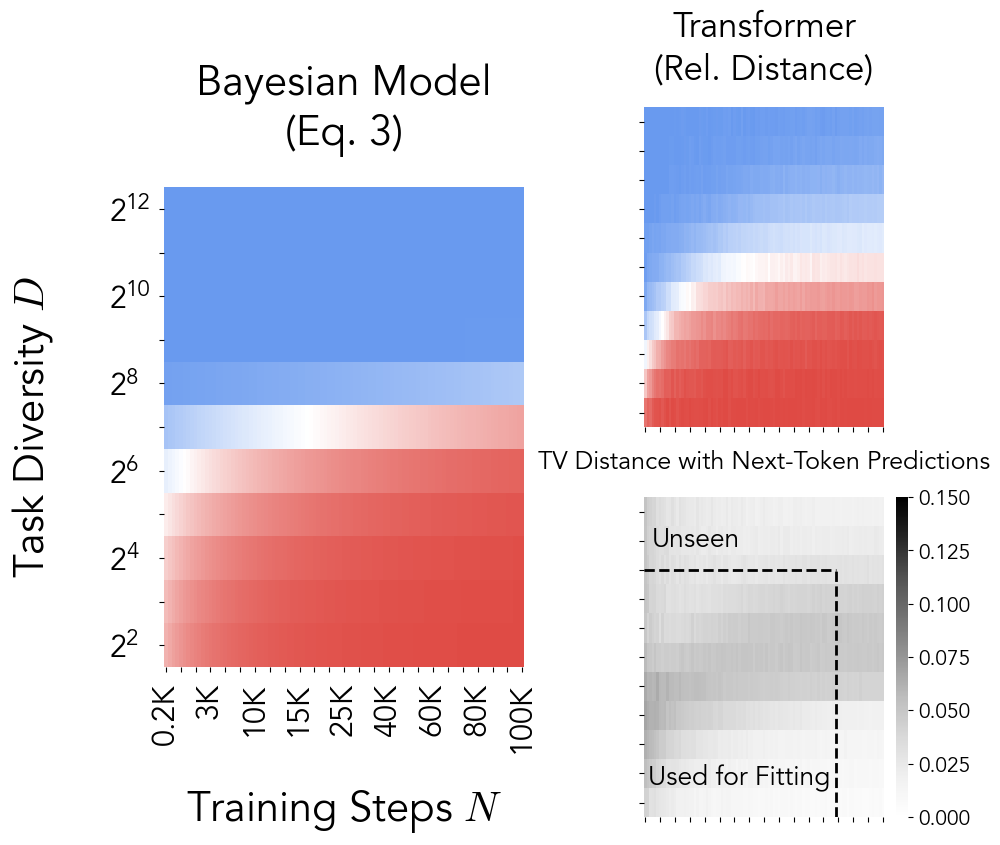

In [17]:
for arg_combo in ablation_arg_combos:
    print(f"plotting {arg_combo['name']}")
    fig_gen.generate_prediction_comparison_plot(
        config={
            "fixed_values": fixed_values,
            "comparison_col": "relative_distance_train",
            "fit_results_col": arg_combo["name"],
            "custom_name": arg_combo["name"],
        },
        show=True,
        save=True,
    )